## Analysis of Southbound wait times which are noticeably lower in 2015

In [62]:
from BorderQuery import select_mungedata
from dbhelper import get_crossings
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [23]:
xing = get_crossings()

In [70]:
df = {}
for i in [1, 5, 16, 20]:
    df[i] = select_mungedata(2, i, '2007-1-1')

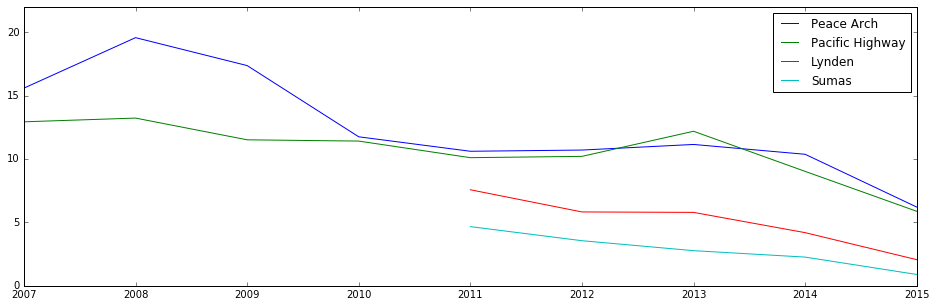

In [33]:
plt.figure(figsize=(16,5))

for i in [1, 5, 16, 20]:
    yearly_mean = df[i].groupby('year').waittime.mean()
    plt.plot(yearly_mean.index, yearly_mean.values, label=xing.loc[i, 'location_name'])
    plt.legend()
    plt.ylim([0,22])

plt.ticklabel_format(useOffset=False) 
plt.show()

## Drop in wait times is noticeable across all crossings

* This explains why model is not as good as it should be
    * Year-based model does not account for drift well
    * Pronounced drop at Peace Arch and Pacific Hwy in 2015 is not handled well by estimates of one year at a time

* The model needs to predict at shorter time intervals so drift can be taken into account

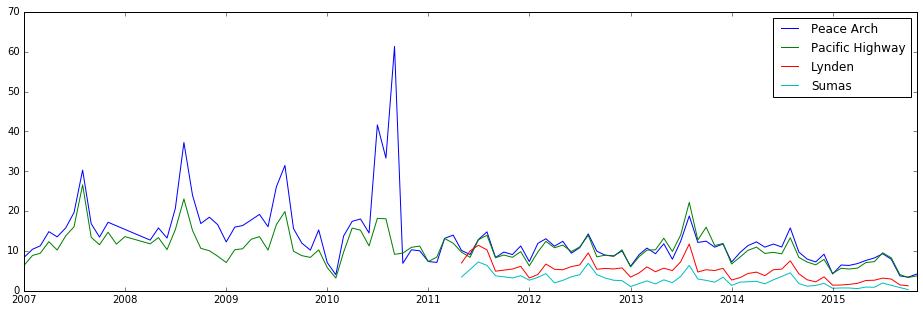

In [61]:
import datetime
plt.figure(figsize=(16,5))

for i in [1, 5, 16, 20]:
    monthly = df[i].groupby(['year', 'month']).waittime.mean()
    months = [datetime.date(y, m, 1) for y, m in monthly.index.values]
    plt.plot(months, monthly.values, label=xing.loc[i, 'location_name'])
    plt.legend()

plt.show()

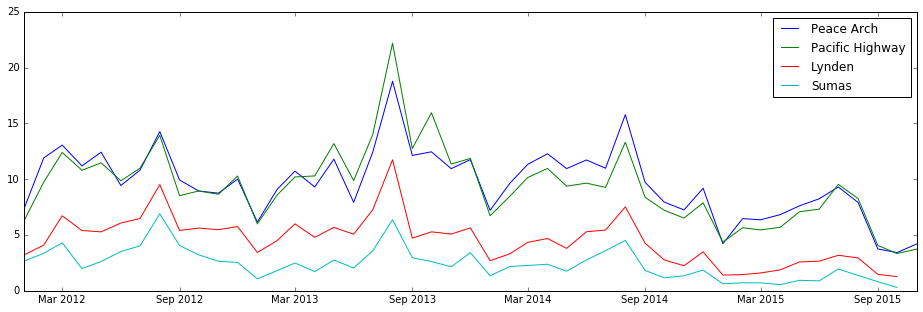

In [71]:
import datetime
plt.figure(figsize=(16,5))

for i in [1, 5, 16, 20]:
    monthly = df[i][df[i].year > 2011].groupby(['year', 'month']).waittime.mean()
    months = [datetime.date(y, m, 1) for y, m in monthly.index.values]
    plt.plot(months, monthly.values, label=xing.loc[i, 'location_name'])

plt.legend()
plt.show()

## Conclusions
* Data before 2011 is useless for predictions
* Spikes are common across crossings, with main difference being scale.

## Verify with Peace Arch predictions.  Train from 2011, instead of 2008.

In [63]:
from BorderQuery import select_mungedata, insert_predictions, select_features
from BorderModel import BorderData, handle_categoricals, model_years
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.grid_search import GridSearchCV
import pandas as pd

In [69]:
df_pa = select_mungedata(2, 1, '2012-1-1')
data = BorderData(df_pa, categoricals=['event'])

model = ExtraTreesRegressor(n_jobs=-1, n_estimators=96, bootstrap=True, oob_score=True)
params = {}
grid = GridSearchCV(model, params, cv=data.cv_train)
grid.fit(data.X_train, data.y_train)

data.predict(grid)
data.predict_ensemble()
data.print_metrics(grid)

OOB:  0.896279696084
Best score:  0.60175659561
** MSE for last cv fold **
Baseline :  96.7590735774
Model    :  98.7464957076
Ensemble :  90.6701558165
Weights  :  (1.0459654351365466, 0.95376607461015761)
** R^2 for last cv fold **
Baseline :  0.14722281598
Model    :  0.129706854066
Ensemble :  0.200886931912
** Explained variance for last cv fold **
Baseline :  0.304333505904
Model    :  0.315978315963
Ensemble :  0.348917127734


### Definite improvement.  Previous best model score was .07.

## A rolling 12 month average smooths out seasonality, leaving only trend

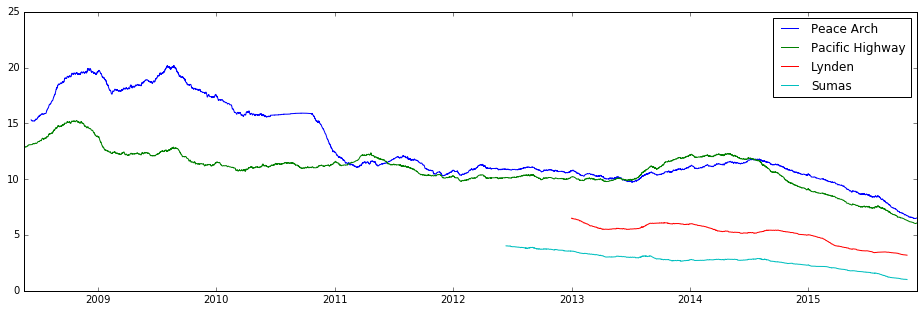

In [81]:
import datetime
plt.figure(figsize=(16,5))

for i in [1, 5, 16, 20]:
    plt.plot(pd.rolling_mean(df[i].set_index('date').waittime, 17520), label=xing.loc[i, 'location_name'])

plt.legend()
plt.show()

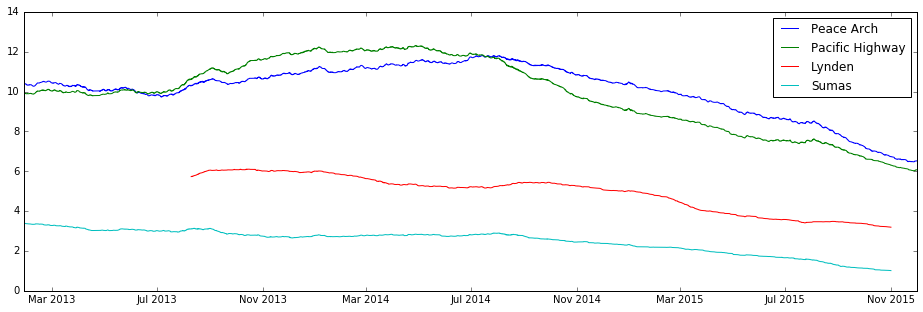

In [82]:
import datetime
plt.figure(figsize=(16,5))

for i in [1, 5, 16, 20]:
    plt.plot(pd.rolling_mean(df[i][df[i].year > 2011].set_index('date').waittime, 17520), label=xing.loc[i, 'location_name'])

plt.legend()
plt.show()